In [1]:
import pandas as pd
from pathlib import Path
import networkx as nx
from bg_atlasapi import BrainGlobeAtlas
import matplotlib.pyplot as plt
import numpy as np
import requests
import seaborn as sns
from io import StringIO
import igraph as ig
import leidenalg

plt.rcParams['xtick.bottom'] = True  # Show ticks at the bottom of the x-axis
plt.rcParams['xtick.top'] = True     # Show ticks at the top of the x-axis
plt.rcParams['ytick.left'] = True    # Show ticks on the left side of the y-axis
plt.rcParams['ytick.right'] = True   # Show ticks on the right side of the y-axis


plt.rcParams['axes.edgecolor'] = 'k'
plt.rcParams['xtick.color'] = 'k'
plt.rcParams['ytick.color'] = 'k'

plt.rcParams['axes.linewidth'] = 2
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['ytick.major.width'] = 2

def node_indices(G):

    node_strength = {node: sum(weight['weight'] for _, weight in G[node].items()) for node in G.nodes()}
    betweenness = nx.betweenness_centrality(G, weight='weight')
    eigenvector = nx.eigenvector_centrality_numpy(G, weight='weight')
    closeness = nx.closeness_centrality(G, distance='weight')
    in_degree = dict(G.in_degree(weight='weight'))
    out_degree = dict(G.out_degree(weight='weight'))
    pagerank = nx.pagerank(G, weight='weight')
    clustering = nx.clustering(G, weight='weight')
    hubs, authorities = nx.hits(G, max_iter=1000, tol=1e-08, nstart=None, normalized=True)
    load_centrality = nx.load_centrality(G, weight='weight')
    katz = nx.katz_centrality_numpy(G, weight='weight')


    results_df = pd.DataFrame({
        'Node Strength': node_strength, # sum of all newtork weights
        'Betweenness Centrality': betweenness, # number of shortest path passing through the node
        'Eigenvector Centrality': eigenvector, # the degree to which a node is connected to other node with high degree
        #'Local Efficiency': local_efficiency_scores,
        'Closeness Centrality': closeness,
        'In-degree': in_degree,
        'Out-degree': out_degree,
        'PageRank': pagerank,
        'Clustering Coefficient': clustering,
        'Hubs Score': hubs, # Hubs estimates the node value based on outgoing links.
        'Authorities Score': authorities, # Authorities estimates the node value based on the incoming links
        'Load Centrality': load_centrality, # similar to betweenness
        'Katz Centrality': katz # similar to eigenvestor and pagerank
    })

    return results_df


In [2]:
url = "http://download.alleninstitute.org/publications/A_high_resolution_data-driven_model_of_the_mouse_connectome/normalized_connection_density.csv"
response = requests.get(url)
conn = pd.read_csv(StringIO(response.text), sep=',', header=[0, 1], index_col=0)


In [4]:
observer = pd.read_excel('Data/areas_observer_density.xlsx')
observer = observer[~observer['acronym'].isin(['LSS', 'SNl', 'InCo', 'NC', 'PIN', 'REth','AHA','PSCH','AD','AV'])]
observer.sort_values(by='order',inplace=True)

demonstrator = pd.read_excel('Data/areas_demonstrator_density.xlsx')
demonstrator = demonstrator[~demonstrator['acronym'].isin(['LSS', 'SNl', 'InCo', 'NC', 'PIN', 'REth','AHA','PSCH', 'III','AD','AV'])]
demonstrator = demonstrator.sort_values(by='order').reset_index(drop=True)

observer['observer_only']=~observer['acronym'].isin(demonstrator['acronym'])

observer_conn_raw = conn['ipsi'].loc[observer['acronym'].values,observer['acronym'].values]
np.fill_diagonal(observer_conn_raw.values, np.nan)

demonstrator_conn_raw = conn['ipsi'].loc[demonstrator['acronym'].values,demonstrator['acronym'].values]
np.fill_diagonal(demonstrator_conn_raw.values, np.nan)

observer_only_conn_raw = conn['ipsi'].loc[observer[observer['observer_only']]['acronym'].values,observer[observer['observer_only']]['acronym'].values]
np.fill_diagonal(observer_only_conn_raw.values, np.nan)


acro2col = {row['acronym']:row['struct_color'] for i,row in observer.iterrows()}
acro2name = {row['acronym']:row['name'] for i,row in observer.iterrows()}
acro2struct = {row['acronym']:row['structure'] for i,row in observer.iterrows()}



## Fig. 5 A

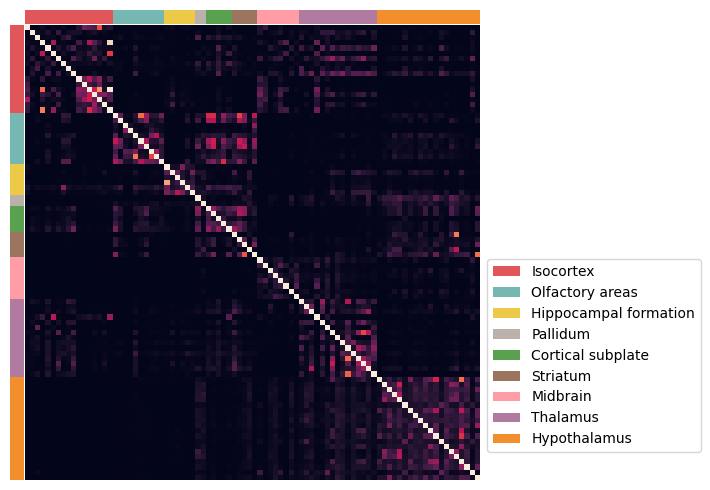

In [5]:
# Observer connectome
connectome = observer_conn_raw.copy()
np.fill_diagonal(connectome.values, connectome.max().max())
cm = sns.clustermap(
    connectome,row_cluster=False, col_cluster=False, col_colors=observer['struct_color'].values,row_colors=observer['struct_color'].values, cbar_pos=None, cbar_kws=None,dendrogram_ratio=(0,0),figsize=(5,5),
    yticklabels=False, xticklabels=False
)

from matplotlib.patches import Patch
maps = list()
cols = observer[['structure','struct_color']].drop_duplicates()
for i,row in cols.iterrows():
    maps.append( Patch(facecolor=row['struct_color'], label=row['structure']) )

plt.legend(handles=maps,bbox_to_anchor=(1.5, 0.5))


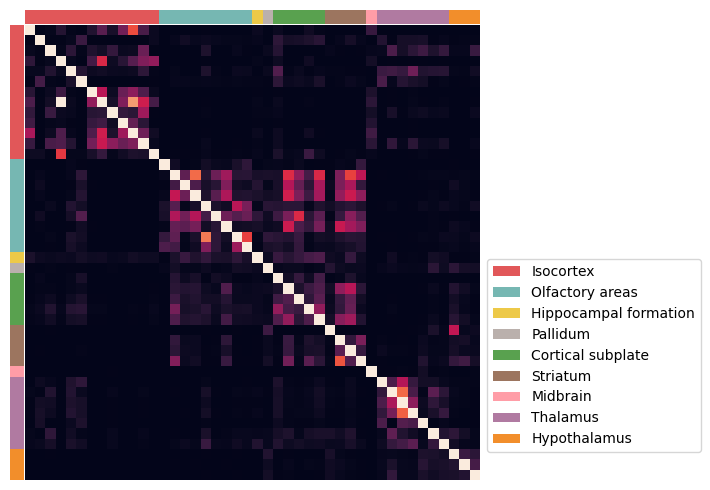

In [6]:
# Demonstrator connectome
connectome = demonstrator_conn_raw.copy()
np.fill_diagonal(connectome.values, connectome.max().max())
cm = sns.clustermap(
    connectome,row_cluster=False, col_cluster=False, col_colors=demonstrator['struct_color'].values,row_colors=demonstrator['struct_color'].values, cbar_pos=None, cbar_kws=None,dendrogram_ratio=(0,0),figsize=(5,5),
    yticklabels=False, xticklabels=False
)

from matplotlib.patches import Patch
maps = list()
cols = demonstrator[['structure','struct_color']].drop_duplicates()
for i,row in cols.iterrows():
    maps.append( Patch(facecolor=row['struct_color'], label=row['structure']) )

plt.legend(handles=maps,bbox_to_anchor=(1.5, 0.5))

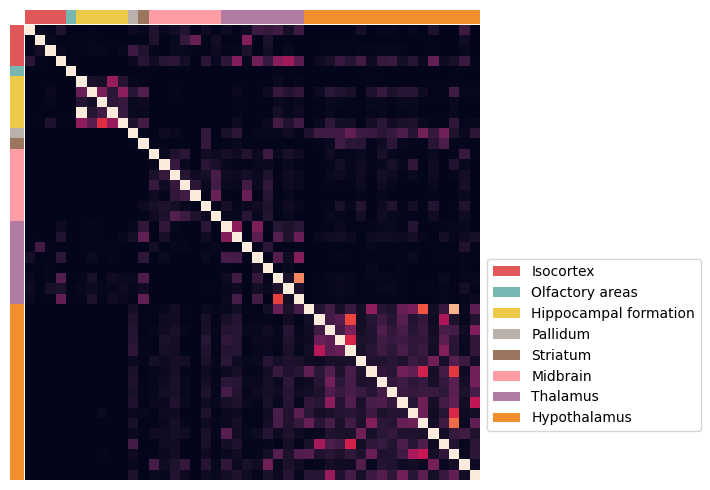

In [7]:
# Observer Only connectome
connectome = observer_only_conn_raw.copy()
np.fill_diagonal(connectome.values, connectome.max().max())
cm = sns.clustermap(
    connectome,row_cluster=False, col_cluster=False, col_colors=observer[observer['observer_only']]['struct_color'].values,row_colors=observer[observer['observer_only']]['struct_color'].values, cbar_pos=None, cbar_kws=None,dendrogram_ratio=(0,0),figsize=(5,5),
    yticklabels=False, xticklabels=False
)

from matplotlib.patches import Patch
maps = list()
cols = observer[observer['observer_only']][['structure','struct_color']].drop_duplicates()
for i,row in cols.iterrows():
    maps.append( Patch(facecolor=row['struct_color'], label=row['structure']) )

plt.legend(handles=maps,bbox_to_anchor=(1.5, 0.5))

# Fig. 5 B

In [8]:

iG = ig.Graph(directed=True)

iG.add_vertices(len(observer_conn_raw.index))
iG.vs['name'] = list(observer_conn_raw.index)

edges = list()
weight = list()
for n,i in enumerate(observer_conn_raw.index):
    for j in range(n):
        if (i!=j):
            if  (n,j) not in edges:
                edges.append((n,j))
                weight.append(observer_conn_raw.loc[i,observer_conn_raw.index[j]])
                edges.append((j,n))
                weight.append(observer_conn_raw.loc[observer_conn_raw.index[j],i])

iG.add_edges(edges)
iG.es['weight'] = weight

In [9]:


# Perform community detection using the Leiden algorithm
partition = leidenalg.find_partition(iG, leidenalg.ModularityVertexPartition, weights='weight', n_iterations=-1, seed=42)

# Print the result
print("Number of communities:", len(partition))
print("Membership of each node:", partition.membership)

# Optional: Print the modularity of the partition
print("Quality of the detected communities:", partition.quality())

Number of communities: 5
Membership of each node: [2, 3, 1, 2, 3, 2, 3, 1, 1, 3, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 4, 4, 4, 1, 4, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 2, 2, 0, 2, 2, 2, 0, 2, 3, 3, 3, 2, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0]
Quality of the detected communities: 0.41820816533992017


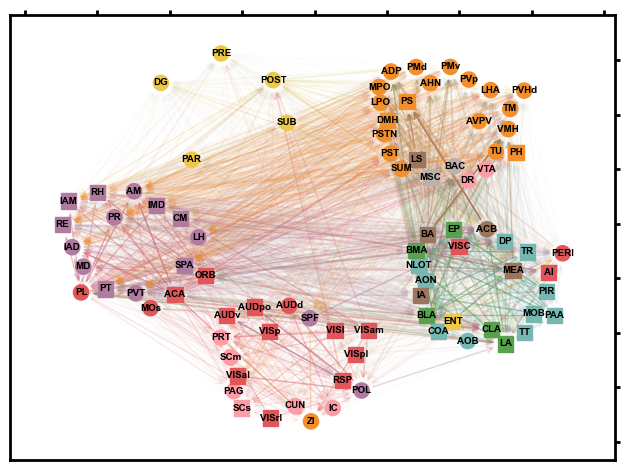

In [10]:
partition_map = {n:p for n,p in zip(iG.vs['name'], partition.membership)}
unique_partitions = np.unique(list(partition_map.values()))
import networkx as nx
import matplotlib.pyplot as plt

#fig, ax = plt.subplots()
# Compute positions for the node clusters as if they were themselves nodes in a
# supergraph using a larger scale factor
supergraph = nx.cycle_graph(len(partition))
superpos = nx.spring_layout(supergraph, scale=2.55, seed=42)

# Use the "supernode" positions as the center of each node cluster
centers = list(superpos.values())
pos = {}
community_name = dict()

G = nx.DiGraph()
# add nodes
for n,i in enumerate(observer_conn_raw.index):
    G.add_node(i,color=observer.struct_color.iloc[n],structure=observer.structure.iloc[n],name=observer.name.iloc[n])

# add edges
for n,i in enumerate(observer_conn_raw.index):
    for j in range(n):
        if (i!=observer_conn_raw.index[j]):
            if acro2struct[i] != acro2struct[observer_conn_raw.index[j]]:
                G.add_edge(i,observer_conn_raw.index[j],weight=observer_conn_raw.loc[i,observer_conn_raw.index[j]],color=observer.struct_color.iloc[n])
                G.add_edge(observer_conn_raw.index[j],i,weight=observer_conn_raw.loc[observer_conn_raw.index[j],i],color=observer.struct_color.iloc[j])

is_observer = observer['observer_only'].values

# Compute positions for the node clusters as if they were themselves nodes in a supergraph
supergraph = nx.cycle_graph(len(unique_partitions))
superpos = nx.spring_layout(supergraph, scale=2.55, seed=42)

# Use the "supernode" positions as the center of each node cluster
centers = list(superpos.values())
pos = {}
for center, comm in zip(centers, unique_partitions):
    list_nodes = [node for node in list(G.nodes()) if partition_map[node] == comm]
    subgraph = G.subgraph(list_nodes)
    pos.update(nx.spring_layout(subgraph, center=center, seed=42,scale=1.1, iterations=10))

# Define observer and non-observer nodes
observer_nodes = [n for n, is_obs in zip(G.nodes(), is_observer) if is_obs]
observer_nodes_color = [acro2col[acro] for acro in observer_nodes]
non_observer_nodes = [n for n, is_obs in zip(G.nodes(), is_observer) if not is_obs]
non_observer_nodes_color = [acro2col[acro] for acro in non_observer_nodes]

nx.draw_networkx_nodes(G, pos=pos, nodelist=observer_nodes, node_shape='o', node_color=observer_nodes_color, node_size=120)
nx.draw_networkx_nodes(G, pos=pos, nodelist=non_observer_nodes, node_shape='s', node_color=non_observer_nodes_color, node_size=120)

# Draw edges
norm_weights = np.array([np.abs(i[-1]['weight']) for i in G.edges(data=True)])
nx.draw_networkx_edges(G, pos, edge_color=[i[-1]['color'] for i in G.edges(data=True)], alpha=norm_weights/norm_weights.max(), arrows=True, arrowstyle="->", arrowsize=10)

# Draw labels
nx.draw_networkx_labels(G, pos, font_size=7, font_family='arial', font_weight='bold')

font = {"color": "k", "fontweight": "bold", "fontsize": 7}

plt.grid(False)
plt.tight_layout()
#plt.savefig('figures/observer_area_network_partition_shared_not_reference.png',dpi=600)
plt.show()
